# Predicting Customer Churn with Machine Learning
**Author:** WANYONYI ALEX WAFULA

This notebook is a capstone-style, blog-friendly walkthrough of a binary classification problem: predicting customer churn using the Telco Customer Churn dataset. We'll cover data loading, cleaning, exploratory data analysis (EDA), feature engineering, model training with Logistic Regression and Random Forest, hyperparameter tuning using `GridSearchCV`, and model evaluation with accuracy, confusion matrix, and ROC-AUC.

---

## 1. Dataset Overview

The data set to be used is called  `Telco-Customer-Churn.csv` and sits in the same directory as this notebook. First i'll load it and display a quick overview of the data.

In [14]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading the dataset
df = pd.read_csv('Telco-Customer-Churn.csv')
print('Dataset loaded. Shape:', df.shape)
df.head()

Dataset loaded. Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Quick summary

Inspect basic information such as missing values, data types, and target distribution.

In [15]:
# Basic info
df.info()

# Missing values
pd.DataFrame({'missing_count': df.isnull().sum(), 'missing_pct': df.isnull().mean() * 100}).sort_values('missing_count', ascending=False).head(20)

# Target distribution
print('\nTarget distribution:')
print(df['Churn'].value_counts())
print('\nTarget distribution (percentage):')
print(df['Churn'].value_counts(normalize=True) * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 2. Data Cleaning and Preprocessing

Now its time to perform the following steps:
- Convert columns with numeric values stored as objects to numeric types (e.g., `TotalCharges`).
- Handle missing or erroneous values.
- Encode categorical variables.
- Split into train/test sets and scale features where appropriate.

In [16]:
# Copy dataset for cleaning
data = df.copy()

# Inspect TotalCharges type issue (common in this dataset)
print('TotalCharges dtype before:', data['TotalCharges'].dtype)

# Convert TotalCharges to numeric, coerce errors to NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
print('Missing TotalCharges after conversion:', data['TotalCharges'].isnull().sum())

# Often the NaNs are for customers with no tenure; we'll fill with 0 or median depending on context
data['TotalCharges'].fillna(0, inplace=True)

# Drop customerID as it's an identifier
if 'customerID' in data.columns:
    data.drop('customerID', axis=1, inplace=True)

# Confirm no remaining nulls
print('\nAny remaining missing values?')
print(data.isnull().sum().sum())
data.shape

TotalCharges dtype before: object
Missing TotalCharges after conversion: 11

Any remaining missing values?
0


(7043, 20)

### Encoding and feature selection

Now separate numerical and categorical columns and build preprocessing pipelines. For many categorical variables one-hot encoding will be used. For binary categories like 'Yes'/'No',  convert to 0/1.

In [17]:
# Identify categorical and numerical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
print('Numerical columns:', num_cols)
print('Categorical columns:', cat_cols)

# Convert some obvious binary object columns to numeric 0/1 (e.g. 'Yes'/'No')
binary_map = {'Yes': 1, 'No': 0}
for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    if col in data.columns and data[col].dtype == 'object':
        data[col] = data[col].map(binary_map)

# Some columns have values like 'No internet service' which we can treat as 'No' for related services
replace_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for col in replace_cols:
    if col in data.columns:
        data[col] = data[col].replace({'No internet service': 'No'})

# Recompute categorical columns after replacements
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
print('Updated categorical columns:', cat_cols)

# We'll build a ColumnTransformer for preprocessing
numeric_features = [c for c in num_cols if c != 'Churn']
categorical_features = cat_cols[:]
numeric_features, categorical_features

Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
Updated categorical columns: ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaymentMethod'])

In [18]:
# Preprocessing transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare X and y
X = data.drop('Churn', axis=1)
y = data['Churn'].astype(int)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (5634, 19) Test shape: (1409, 19)


## 3. Exploratory Data Analysis (EDA)

Now lets visualize target imbalance, several features vs churn, and correlation among numerical featuresand also Keep explanations short and reader-friendly.

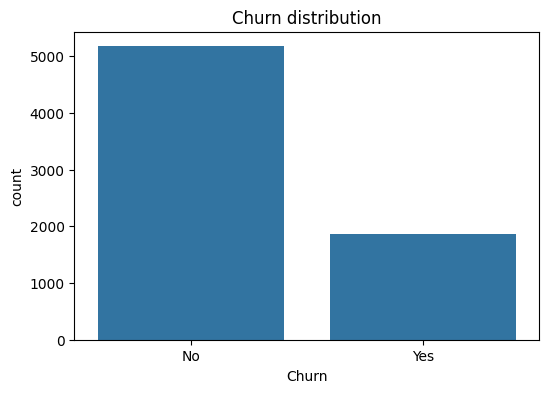

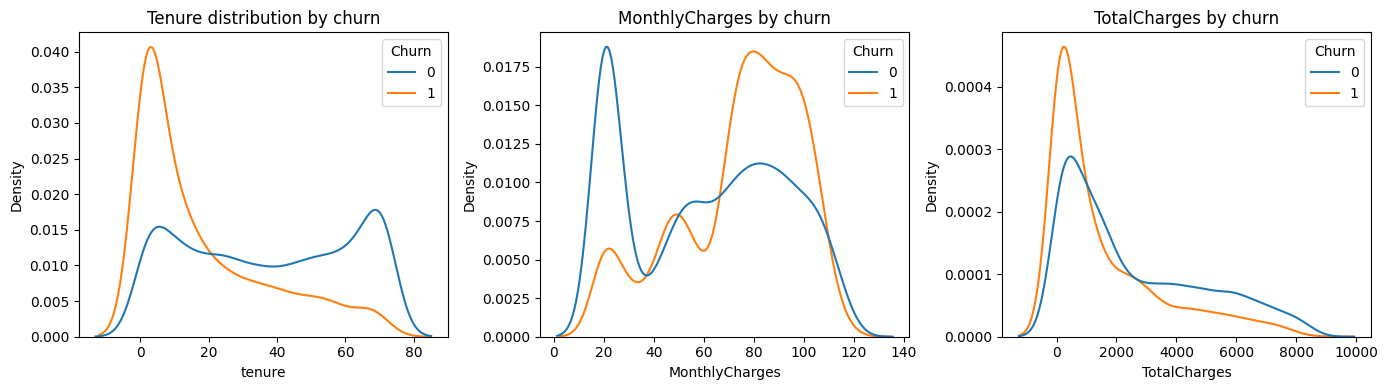

In [21]:
# Target balance visualization
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=data)
plt.title('Churn distribution')
plt.xticks([0,1], ['No','Yes'])
plt.show()

# Numeric feature distributions vs churn (example: tenure, MonthlyCharges, TotalCharges)
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.kdeplot(data=data, x='tenure', hue='Churn', common_norm=False)
plt.title('Tenure distribution by churn')
plt.subplot(1,3,2)
sns.kdeplot(data=data, x='MonthlyCharges', hue='Churn', common_norm=False)
plt.title('MonthlyCharges by churn')
plt.subplot(1,3,3)
sns.kdeplot(data=data, x='TotalCharges', hue='Churn', common_norm=False)
plt.title('TotalCharges by churn')
plt.tight_layout()
plt.show()

### Categorical feature examples



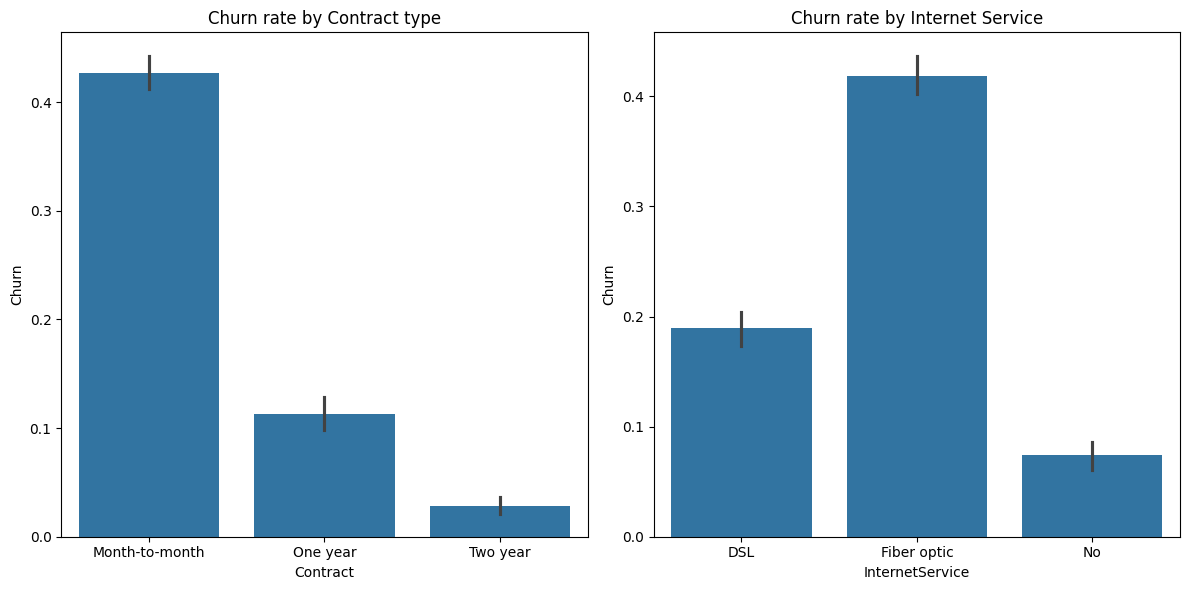

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.barplot(x='Contract', y='Churn', data=data)
plt.title('Churn rate by Contract type')
plt.subplot(1,2,2)
sns.barplot(x='InternetService', y='Churn', data=data)
plt.title('Churn rate by Internet Service')
plt.tight_layout()
plt.show()

### Correlation heatmap (numerical)

A quick look at relationships between numerical variables.

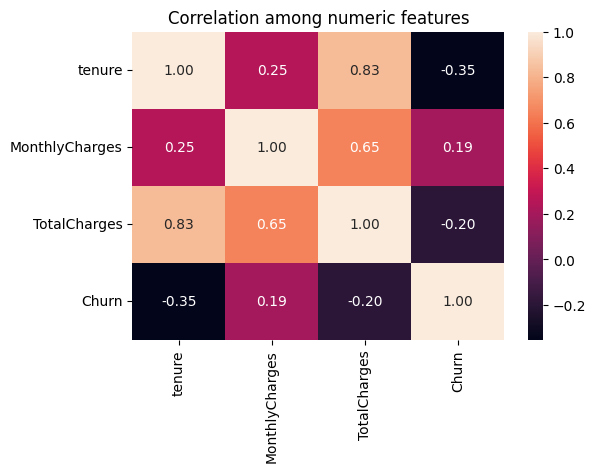

In [23]:
plt.figure(figsize=(6,4))
sns.heatmap(data[['tenure','MonthlyCharges','TotalCharges','Churn']].corr(), annot=True, fmt='.2f')
plt.title('Correlation among numeric features')
plt.show()

## 4. Model Training

Now pipelines are created for both Logistic Regression and Random Forest. The pipelines combine preprocessing (defined earlier) with the estimator so that grid search can tune end-to-end.

In [24]:
# Pipelines
logistic = Pipeline(steps=[('preprocessor', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
rf = Pipeline(steps=[('preprocessor', preprocessor), ('clf', RandomForestClassifier(random_state=42))])

# Fit baseline models quickly to get a benchmark
logistic.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Baseline evaluation
for name, model in [('Logistic Regression', logistic), ('Random Forest', rf)]:
    preds = model.predict(X_test)
    print(f'--- {name} ---')
    print('Accuracy:', accuracy_score(y_test, preds))
    print('ROC-AUC:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print()

--- Logistic Regression ---
Accuracy: 0.7963094393186657
ROC-AUC: 0.8425249941873982

--- Random Forest ---
Accuracy: 0.7764371894960965
ROC-AUC: 0.8107856054147615



## 5. Hyperparameter Tuning (GridSearchCV)

Tune a small set of hyperparameters for both classifiers using `GridSearchCV` with stratified cross-validation. This keeps compute reasonable while improving performance.

In [ ]:
# Define parameter grids
param_grid_logistic = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}
# GridSearchCV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_logistic = GridSearchCV(logistic, param_grid_logistic, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit grids ,( takes time )
grid_logistic.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

print('Best logistic params:', grid_logistic.best_params_)
print('Best logistic CV ROC-AUC:', grid_logistic.best_score_)
print('Best RF params:', grid_rf.best_params_)
print('Best RF CV ROC-AUC:', grid_rf.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best logistic params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best logistic CV ROC-AUC: 0.8450623888467188
Best RF params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best RF CV ROC-AUC: 0.8423043578679913


## 6. Model Evaluation and Comparison

Evaluate tuned models on the hold-out test set using accuracy, confusion matrix, classification report, and ROC-AUC. Also plot ROC curves and feature importances for the Random Forest.

--- Logistic Regression (tuned) ---
Accuracy: 0.7934705464868701
ROC-AUC: 0.8415820610194011

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



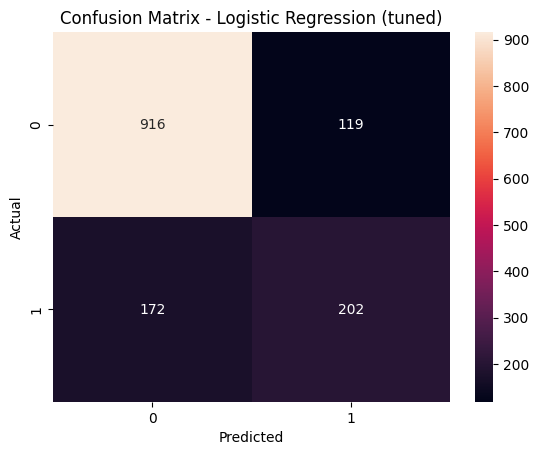

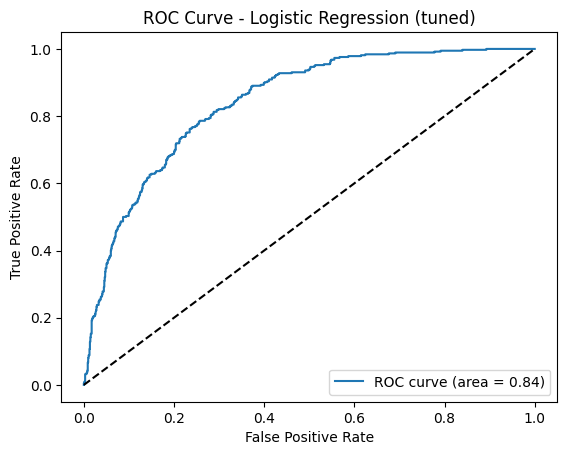

--- Random Forest (tuned) ---
Accuracy: 0.794180269694819
ROC-AUC: 0.8382830866206826

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



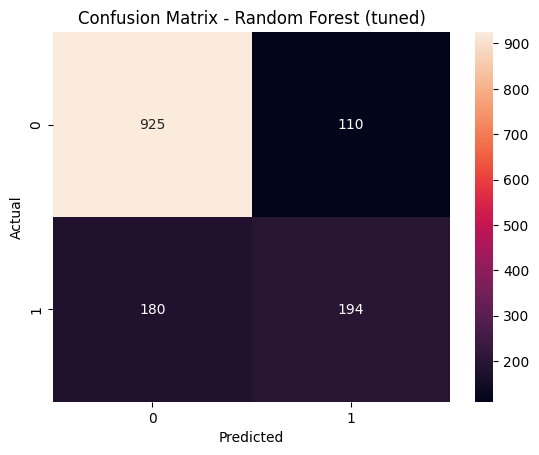

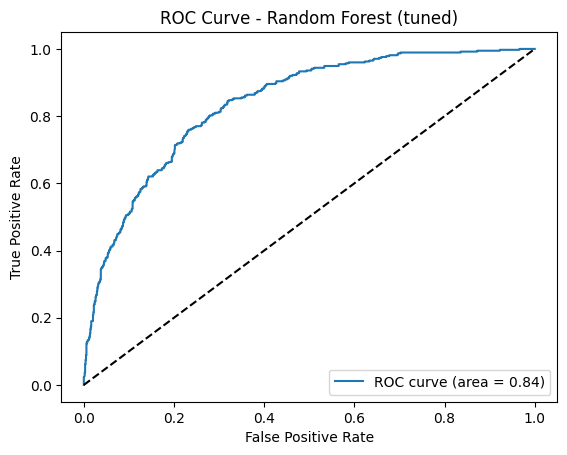

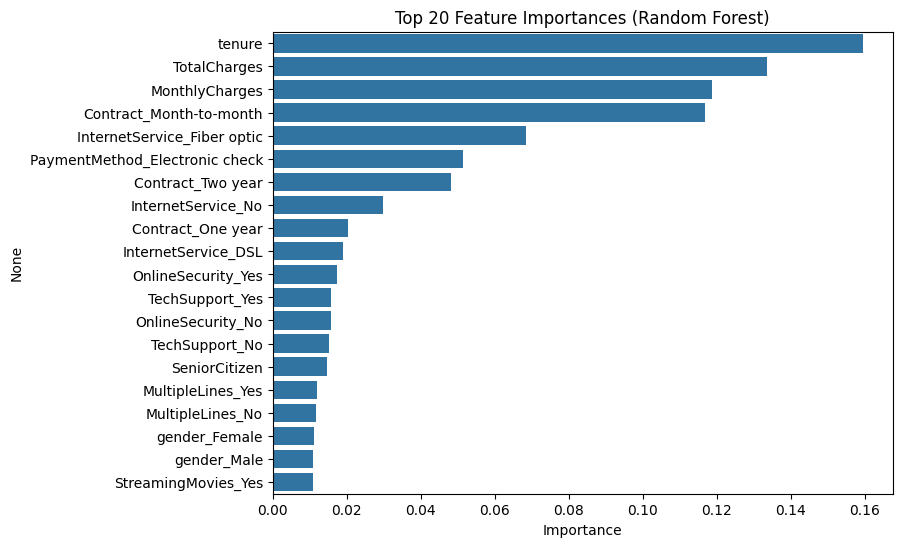

In [26]:
best_logistic = grid_logistic.best_estimator_
best_rf = grid_rf.best_estimator_

models = [('Logistic Regression (tuned)', best_logistic), ('Random Forest (tuned)', best_rf)]

for name, model in models:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f'--- {name} ---')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('ROC-AUC:', roc_auc_score(y_test, y_proba))
    print('\nClassification report:\n', classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

# Feature importance for Random Forest
# We need to extract feature names after one-hot encoding
ohe = best_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)
importances = best_rf.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.show()

## 7. Conclusion and Next Steps

**Conclusion:**
- Summarize which model performed better and key insights about features that drive churn.

**Next steps / improvements:**
- Perform more extensive hyperparameter tuning and consider randomized search for broader search.
- Try more models (XGBoost, LightGBM) and ensemble approaches.
- Calibrate probabilities if the predicted probabilities are important.
- Deploy the best model as an API and create a dashboard for monitoring.

---
*This notebook was written to be educational and reproducible — change parameter grids or preprocessing choices to experiment further.*